In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data109938


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: 无法创建目录"/home/aistudio/external-libraries": 文件已存在
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 5.7 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.933523	training's binary_logloss: 0.249533	valid_1's auc: 0.892153	valid_1's binary_logloss: 0.290676
Fold  1 AUC : 0.892153
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.954902	training's binary_logloss: 0.224771	valid_1's auc: 0.888907	valid_1's binary_logloss: 0.289767
Early stopping, best iteration is:
[64]	training's auc: 0.937329	training's binary_logloss: 0.246772	valid_1's auc: 0.891066	valid_1's binary_logloss: 0.28752
Fold  2 AUC : 0.891066
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[47]	training's auc: 0.93133	training's binary_logloss: 0.2514	valid_1's auc: 0.875276	valid_1's binary_logloss: 0.31178
Fold  3 AUC : 0.875276
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[54]	training's auc: 0.937112	training's binary_log

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


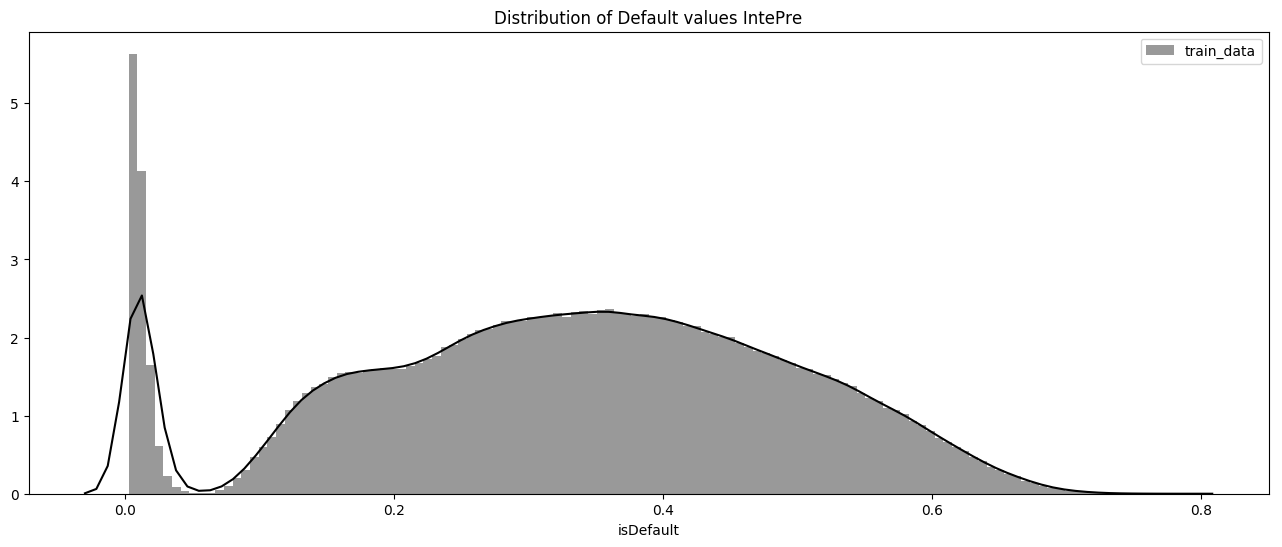

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[53]	training's auc: 0.990736	training's binary_logloss: 0.0367915	valid_1's auc: 0.986415	valid_1's binary_logloss: 0.0447263
Fold  1 AUC : 0.986415
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.989731	training's binary_logloss: 0.0402431	valid_1's auc: 0.98474	valid_1's binary_logloss: 0.0438985
Fold  2 AUC : 0.984740
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.992613	training's binary_logloss: 0.0346112	valid_1's auc: 0.986311	valid_1's binary_logloss: 0.0421044
Early stopping, best iteration is:
[88]	training's auc: 0.99166	training's binary_logloss: 0.0358044	valid_1's auc: 0.986573	valid_1's binary_logloss: 0.0418367
Fold  3 AUC : 0.986573
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.989772	training's

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
train_data = pd.read_csv('raw_data/train_public.csv')
submit_example = pd.read_csv('raw_data/submit_example.csv')
test_public = pd.read_csv('raw_data/test_public.csv')
train_inte = pd.read_csv('raw_data/train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)




# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0



# use_te = train_inte[train_inte.loan_id.isin( InteId )].copy()
# data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]


del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('submission.csv', index=False)

